In [1]:
import numpy as np 
import os
from astropy.io import fits
import healpy as hp
from scipy.interpolate import RegularGridInterpolator, griddata
from healpy.projector import GnomonicProj
import datetime
from zoneinfo import ZoneInfo
from astropy.time import Time
from astropy.table import Table
from astropy.coordinates import SkyCoord, EarthLocation, AltAz
import astropy.units as u
import matplotlib.image as mpig
from gwcs.wcstools import wcs_from_points
from astropy.modeling.projections import Sky2Pix_TAN, Sky2Pix_STG, Sky2Pix_ARC, Sky2Pix_ZEA, Sky2Pix_SIN
#from astropy.modeling import projections
import asdf 
import matplotlib.pyplot as plt
import cv2
import rawpy

In [2]:
def check_projection(zen, r_real):
    str_proj = ['TAN', 'STG', 'ARC', 'ZEA', 'SIN']
    f_proj = [Sky2Pix_TAN(), Sky2Pix_STG(), Sky2Pix_ARC(), Sky2Pix_ZEA(), Sky2Pix_SIN()]
    if zen ==0:
        zen = 0.1
    zen_rad = np.deg2rad(zen)
    r_tan = np.tan(zen_rad) /zen_rad
    r_stg = np.tan(zen_rad/2.) *2/zen_rad
    r_arc = 1.
    r_zea = np.sin(zen_rad/2.) *2/zen_rad
    r_sin = np.sin(zen_rad)/zen_rad
    r_proj = np.array([r_tan, r_stg, r_arc, r_zea, r_sin])
    dr = np.abs(r_real -r_proj)
    r_id = np.argmin(dr)
    #print(r_proj)
    print(str_proj[r_id])
    return f_proj[r_id]

class HealpixData():
    def __init__(self, nside):
        img = np.arange(hp.nside2npix(nside))
        lat, lon = hp.pix2ang(nside, img, nest=True)
        self.lat = lat
        self.lon = lon

class ImageData():
    def __init__(self, img=None, x=None, y=None):
        self.img = img
        self.x = x
        self.y = y

class all_sky_image():
    def __init__(self, filepath, sex_ext, rdata, dt, elocation, proj_size, str_r):
        self.filepath = filepath
        self.sex = sex_ext
        self.rawdata = rdata
        self.elocation = elocation # None 
        # EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)
        self.dt = dt # None # datetime.datetime(yr,mon,day,hr,min,sec,tzinfo=tz)
        self.fvalue = 0.
        self.cutdata = None
        self.hdata = HealpixData(1024) # healpix data for projection, nside=1024
        self.bdata = HealpixData(4) # healpix data for rotation, nside=4
        self.divdeg = [45., 65., 90.] # the boundaries to divide the FoV into three segments
        self.divnum = [0., 0., 0.] # the number of healpix above the boundaries.
        self.func = lambda x,y,z: hp.vec2pix(1024,x,y,z,nest=True) # function for hdata
        self.gwcs_azalt = None
        self.new_gwcs = 0
        self.tab = None
        self.fproj = Sky2Pix_ARC() # the image projection, the default is ARC
        self.xproj = proj_size
        self.yproj = proj_size
        self.str_r = str_r
        self.px = None
        self.py = None
        self.pdata = ImageData()
        self.frame = None        
        self.cen = [0, 0, 0]

    def _set_frame(self):
        obstime = Time(self.dt)
        self.frame = AltAz(obstime=obstime, location=self.elocation)

    def _set_gwcs_azalt(self, p_degree):
        tab_radec = SkyCoord(self.tab['index_ra'], self.tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
        tab_altaz = tab_radec.transform_to(self.frame)
        xy = ((self.tab['field_x'],self.tab['field_y']))
        rd0 = SkyCoord(0., 90.,unit='deg',frame='icrs')
        self.gwcs_azalt = wcs_from_points(xy, tab_altaz, proj_point=rd0,\
                             projection=self.fproj,poly_degree=p_degree, polynomial_type='polynomial')

    def _set_cutdata(self):
        col1 = self.cen[0]-self.cen[2]
        col2 = self.cen[0]+self.cen[2]
        row1 = self.cen[1]-self.cen[2]
        row2 = self.cen[1]+self.cen[2]
        self.cutdata = self.rawdata[row1:row2,col1:col2]

    def _center_tab(self):   
        self._set_cutdata()    
        sel_fit = fits.PrimaryHDU(np.array(self.cutdata))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --cpulimit 30 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            self.tab = fits.open(self.filepath+'sel_fit.corr')[1].data
            os.remove(self.filepath+'sel_fit.corr') 
            self._set_gwcs_azalt(p_degree=1)
        else:
            print("The zenith region can not be solved.")                
    
    def _set_pxy(self):
        proj_nx = np.arange(self.xproj)
        proj_ny = np.arange(self.yproj)
        self.px, self.py = np.meshgrid(proj_nx, proj_ny)
        self.px = self.px.flatten()
        self.py = self.py.flatten()

    def _update_tab(self, r_radec):
        sra = str(round(r_radec.ra.deg,3))
        sdec = str(round(r_radec.dec.deg,3))
    
        sel_fit = fits.PrimaryHDU(np.array(self.pdata.img))
        sel_fit.writeto(self.filepath+'sel_fit.fits',overwrite=True)
        os.system('solve-field '+self.filepath+'sel_fit.fits -O --use-source-extractor'\
                  +' --source-extractor-path '+self.sex \
                    +' --x-column xc --y-column yc --sort-column flux --no-plots'\
                        +' --width ' +str(self.xproj)+ ' --height ' +str(self.yproj) \
                            +' --ra '+sra+' --dec '+sdec+' --radius '+self.str_r \
                                +' --cpulimit 20 --scale-units arcsecperpix '\
                                    +' --scale-low 75 --scale-h 105 >> ' +self.filepath+'sel_fit.txt')
        if os.path.exists(self.filepath+'sel_fit.corr'):
            star_tab = fits.open(self.filepath+'sel_fit.corr')[1].data           
            os.remove(self.filepath+'sel_fit.corr') 
            star_x = griddata((self.px, self.py), self.pdata.x.flatten(), \
                              (star_tab['field_x'], star_tab['field_y']), method='linear')
            star_y = griddata((self.px, self.py), self.pdata.y.flatten(), \
                              (star_tab['field_x'], star_tab['field_y']), method='linear')
            star_tab['field_x'] = star_x
            star_tab['field_y'] = star_y
            self.tab = np.append(self.tab, star_tab)
        else:
            print("The region centered on the astronomical coordinates ("+sra+","+sdec+") could not be solved.")

    def _set_bdata(self):
        # [11.7, 23.6, 35.7, 48.2, 60.0, 70.5, 80.4, 90.0]
        # [   4,    8,   16,   16,   16,   16,   16,   16] 
        # If nside = 4, the first 7 circles need to be solved.
        id = np.argsort(self.bdata.lat)
        self.bdata.lat = self.bdata.lat[id]
        self.bdata.lon = self.bdata.lon[id]
        self.divnum[0] = len(self.bdata.lat[self.bdata.lat < np.deg2rad(self.divdeg[0])])
        self.divnum[1] = len(self.bdata.lat[self.bdata.lat < np.deg2rad(self.divdeg[1])])
        self.divnum[2] = len(self.bdata.lat[self.bdata.lat < np.deg2rad(self.divdeg[2])])
    
    def interpol_area(self):
        ny, nx = self.rawdata.shape
        xrange = np.arange(nx)
        yrange = np.arange(ny)

        fr = RegularGridInterpolator((yrange,xrange), self.rawdata ,method='linear', bounds_error=False)
        fdata = fr((self.pdata.y, self.pdata.x))
        self.pdata.img = np.nan_to_num(fdata, nan=0.0, posinf=0.0, neginf=0.0)
        if np.sum(np.isnan(fdata)) > len(fdata)*0.3:
            self.pdata.img = [0]
            print("This region is skipped.")
            #return self.pdata.img

    def rot_area(self, hrot):
        rot_proj = GnomonicProj(rot=(hrot[0],hrot[1]),xsize=self.xproj,ysize=self.yproj)
        glon = rot_proj.projmap(self.hdata.lon, self.func)
        glon = np.rad2deg(glon)
        glat = rot_proj.projmap(self.hdata.lat, self.func)
        glat = 90.-np.rad2deg(glat)
        gx, gy = self.gwcs_azalt.backward_transform(glon,glat)
        self.pdata.x = gx
        self.pdata.y = gy
        if self.new_gwcs==0 :
            self.pdata.x = gx -self.cen[2] + self.cen[0]
            self.pdata.y = gy -self.cen[2] + self.cen[1]
        self.interpol_area()
    
    def estimate_center1(self):
        # 1st to estimate center
        width, height = self.rawdata.shape
        self.cen = [round(height/2.), round(width/2.), round(width/10.)] ## xcenter, ycenter, radius
        if width > height :
            self.cen[2] = round(height/16.)
        #print(self.cen)  
        self._center_tab()
    
    def estimate_center2(self):
        x0, y0 = self.gwcs_azalt.backward_transform(0,90)
        x1, y1 = self.gwcs_azalt.backward_transform(0,75)
        x2, y2 = self.gwcs_azalt.backward_transform(180,75)
        self.cen[0] = round(self.cen[0] + (x0-self.cen[2]))
        self.cen[1] = round(self.cen[1] + (y0-self.cen[2]))
        self.cen[2] = round(np.sqrt((x1-x2)**2.+(y1-y2)**2.)/2.)
        self.fvalue = (np.sqrt((x0-x1)**2.+(y0-y1)**2.)+np.sqrt((x0-x2)**2.+(y0-y2)**2.))/2. # radius
        self.fvalue = self.fvalue /np.deg2rad(90.-75) # f = radius/theta
        print("x,y,radius,fvalue:",[self.cen, self.fvalue])
        self._center_tab()

    def get_tab(self):
        self._set_frame()
        self._set_pxy()
        self._set_bdata()
        self.estimate_center1()
        self.estimate_center2()       
        self.tab['field_x'] = np.round(self.tab['field_x']-self.cen[2] + self.cen[0])
        self.tab['field_y'] = np.round(self.tab['field_y']-self.cen[2] + self.cen[1])
        print('The center area is solved.')

        for i in range(self.divnum[2]): 
            rot_lat = 90.-np.rad2deg(self.bdata.lat[i])
            rot_lon = np.rad2deg(self.bdata.lon[i])
            rot_azalt = SkyCoord(rot_lon, rot_lat, unit=(u.deg, u.deg),frame=self.frame)
            rot_radec = rot_azalt.transform_to('icrs') 
            print(f"@ lat:{round(rot_lat,3)}, lon:{round(rot_lon,3)}, count:{i+1}/{self.divnum[2]}")
            self.rot_area([rot_lon, rot_lat])    
            if len(self.pdata.img) == 1:
                continue 
            self._update_tab(rot_radec)

            if i==(self.divnum[0]-1) or i==(self.divnum[1]-1):
                uu, u_ind = np.unique(self.tab['index_ra'], return_index=True)
                self.tab = self.tab[u_ind]
                self.tab = self.tab[~np.isnan(self.tab['field_x'])]

                sradec = SkyCoord(self.tab['index_ra'], self.tab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
                saltaz = sradec.transform_to(self.frame)
                zen_id = np.argmax(90.-saltaz.alt.deg)
                zen_deg = 90.-saltaz.alt.deg[zen_id]
                print(zen_deg)
                rdis = np.sqrt((self.cen[0]-self.tab['field_x'][zen_id])**2.+(self.cen[1]-self.tab['field_y'][zen_id])**2.)
                r_real = rdis/np.deg2rad(zen_deg)/self.fvalue
                print(r_real)
                self.fproj = check_projection(zen_deg, r_real)  
                self._set_gwcs_azalt(p_degree=4)
                self.new_gwcs = 1

        # get the table 
        self.tab = self.tab[~np.isnan(self.tab['field_x'])]       
        uu, u_ind = np.unique(self.tab['index_ra'], return_index=True)
        self.tab = self.tab[u_ind]  
        self._set_gwcs_azalt(p_degree=6)  

        newtab = Table([self.tab['field_x'],self.tab['field_y'],\
                        self.tab['index_ra'],self.tab['index_dec'],\
                            self.tab['field_ra'],self.tab['field_dec'],\
                                self.tab['match_weight'],self.tab['MAG_AUTO'],self.tab['FLUX_AUTO']],\
                names=['field_x','field_y','index_ra','index_dec','field_ra','field_dec',\
                        'match_weight','mag_auto','flux_auto']) 
        tab_radec = SkyCoord(newtab['index_ra'], newtab['index_dec'], unit=(u.deg, u.deg),frame='icrs')
        tab_altaz = tab_radec.transform_to(self.frame)
        newtab['alt'] = tab_altaz.alt.deg
        newtab['az'] = tab_altaz.az.deg
        self.tab = newtab

In [ ]:
sex_ext = '/usr/local/bin/sex ' # source extractor
ipath = 'your image path'
fname = 't2020-10-19_04-24-26.jpg'

#information of ALi site
tz = ZoneInfo('Asia/Shanghai')
location = ['ALi Observatory', 80.02, 32.32, 5050] #[longitude.deg, latitude.deg, height.m]
elocation = EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)

img = mpig.imread(ipath+fname)
rr = img[:,:,0]
gg = img[:,:,1]
bb = img[:,:,2]
gimg = (0.299*rr + 0.587*gg + 0.114*bb)

# date and time of image
yr = int(fname[1:5])
mon = int(fname[6:8])
day = int(fname[9:11])
hr = int(fname[12:14])
min = int(fname[15:17])
sec = int(fname[18:20])
dt = datetime.datetime(yr,mon,day,hr,min,sec,tzinfo=tz)
obstime = Time(dt)
azalt_frame = AltAz(obstime=obstime, location=elocation)

In [5]:
# The solving region size for Astrometry.net is set to 600*600, 
# with an angular distance of 5 degrees from the center.
result = all_sky_image(ipath, sex_ext, gimg, dt, elocation, 600, '5')
result.get_tab()

x,y,radius,fvalue: [[2548, 1710, 273], 1040.9139432382913]
The center area is solved.
@ lat:78.284, lon:315.0, count:1/88
@ lat:78.284, lon:135.0, count:2/88
@ lat:78.284, lon:225.0, count:3/88
@ lat:78.284, lon:45.0, count:4/88
@ lat:66.444, lon:22.5, count:5/88
@ lat:66.444, lon:157.5, count:6/88
@ lat:66.444, lon:292.5, count:7/88
@ lat:66.444, lon:337.5, count:8/88
@ lat:66.444, lon:112.5, count:9/88
@ lat:66.444, lon:247.5, count:10/88
@ lat:66.444, lon:202.5, count:11/88
@ lat:66.444, lon:67.5, count:12/88
@ lat:54.341, lon:165.0, count:13/88
@ lat:54.341, lon:195.0, count:14/88
@ lat:54.341, lon:345.0, count:15/88
@ lat:54.341, lon:285.0, count:16/88
@ lat:54.341, lon:225.0, count:17/88
@ lat:54.341, lon:45.0, count:18/88
@ lat:54.341, lon:15.0, count:19/88
@ lat:54.341, lon:255.0, count:20/88
@ lat:54.341, lon:315.0, count:21/88
@ lat:54.341, lon:75.0, count:22/88
@ lat:54.341, lon:105.0, count:23/88
@ lat:54.341, lon:135.0, count:24/88
45.01363455152817
0.9639677264541228
ZEA


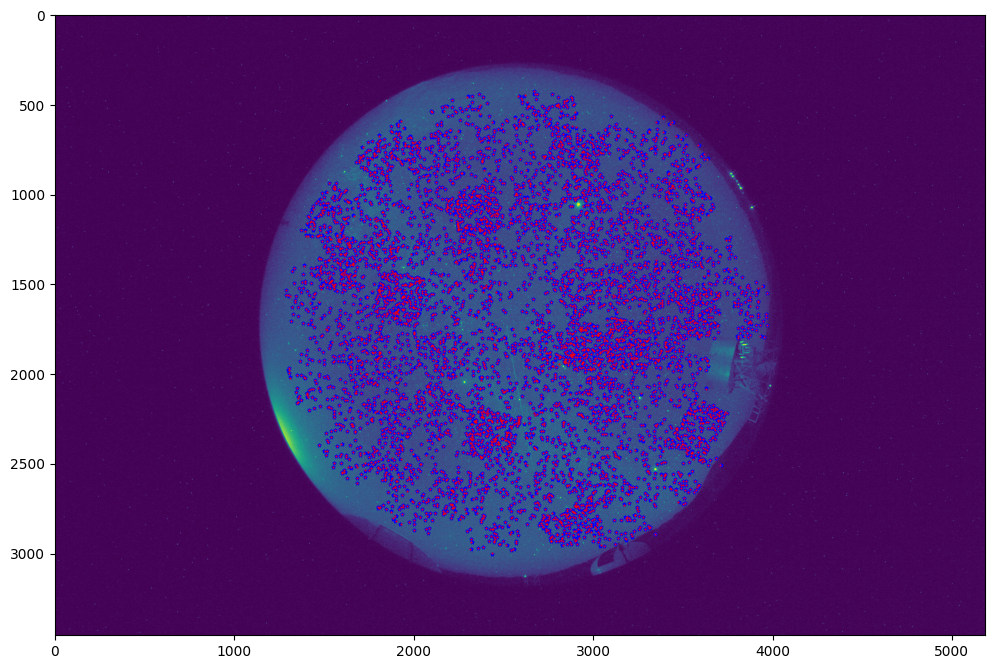

In [6]:
gx, gy = result.gwcs_azalt.backward_transform(result.tab['az'], result.tab['alt'])

fig,ax = plt.subplots(figsize=(12,12),dpi=100)
ax.imshow(result.rawdata)
plt.scatter(gx,gy, c='blue',s=5,marker='*')
plt.scatter(result.tab['field_x'],result.tab['field_y'],s=1,marker='.',c='red')#,edgecolors='red', linewidths=0.5)
plt.show()

In [ ]:
sex_ext = '/usr/local/bin/sex ' # source extractor
ipath = 'your image path'

ifile = 'AllSkyImage000000153.JPG'
img = mpig.imread(ipath+ifile)
idata = np.dot(img[..., :3], [0.299, 0.587, 0.114])

#information of ALi site
tz = ZoneInfo('Asia/Shanghai')
location = ['ALi Observatory', 80.02, 32.32, 5050] #[longitude.deg, latitude.deg, height.m]
elocation = EarthLocation(lon=location[1]*u.deg, lat=location[2]*u.deg, height=location[3]*u.m)

# date and time of image
yr = 2011
mon = 10
day = 31
hr = 0
min = 40
sec = 16
dt = datetime.datetime(yr,mon,day,hr,min,sec,tzinfo=tz)
obstime = Time(dt)
azalt_frame = AltAz(obstime=obstime, location=elocation)

In [9]:
# Due to the low image resolution and a smaller number of stars,
# the solving region size for Astrometry.net is set to 800*800, 
# with an angular distance of 20 degrees from the center.
result = all_sky_image(ipath, sex_ext, idata, dt, elocation, 800, '20')
result.get_tab()

x,y,radius,fvalue: [[305, 258, 50], 191.30412399792056]
The center area is solved.
@ lat:78.284, lon:315.0, count:1/88
@ lat:78.284, lon:135.0, count:2/88
@ lat:78.284, lon:225.0, count:3/88
@ lat:78.284, lon:45.0, count:4/88
@ lat:66.444, lon:22.5, count:5/88
@ lat:66.444, lon:157.5, count:6/88
@ lat:66.444, lon:292.5, count:7/88
The region centered on the astronomical coordinates (340.544,38.2) could not be solved.
@ lat:66.444, lon:337.5, count:8/88
@ lat:66.444, lon:112.5, count:9/88
@ lat:66.444, lon:247.5, count:10/88
@ lat:66.444, lon:202.5, count:11/88
@ lat:66.444, lon:67.5, count:12/88
The region centered on the astronomical coordinates (36.596,38.212) could not be solved.
@ lat:54.341, lon:165.0, count:13/88
The region centered on the astronomical coordinates (17.264,-2.442) could not be solved.
@ lat:54.341, lon:195.0, count:14/88
The region centered on the astronomical coordinates (359.893,-2.445) could not be solved.
@ lat:54.341, lon:345.0, count:15/88
@ lat:54.341, lon:

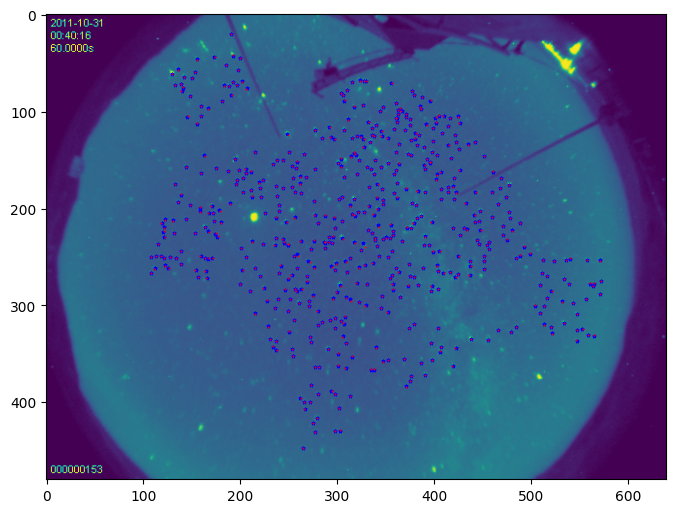

In [10]:
gx, gy = result.gwcs_azalt.backward_transform(result.tab['az'], result.tab['alt'])

fig,ax = plt.subplots(figsize=(8,8),dpi=100)
ax.imshow(result.rawdata)
plt.scatter(gx,gy, c='blue',s=5,marker='*')
plt.scatter(result.tab['field_x'],result.tab['field_y'],s=1,marker='.',c='red')#,edgecolors='red', linewidths=0.5)
plt.show()